In [2]:
import re
from collections import deque
from typing import Optional, Sequence

import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.axes import Axes
from matplotlib.colors import CenteredNorm, LogNorm
from PIL import Image
from scipy.fft import dctn

from pig.entropy.mule.mule_optimizer import MuleOptimizer
from pig.utils.block_utils import bigger_possible_slice, split_shape_in_half


ModuleNotFoundError: No module named 'pig'

In [463]:
def imshow(*imgs):
    fig, axes = plt.subplots(1, len(imgs))

    if not isinstance(axes, np.ndarray):
        axes = np.array([axes])

    for ax, img in zip(axes, imgs):
        ax.axis("off")
        ax.imshow(img, cmap="gray", vmin=0, vmax=255)

    return axes


def dctshow(*imgs):
    fig, axes = plt.subplots(1, len(imgs))

    if not isinstance(axes, np.ndarray):
        axes = np.array([axes])

    norm = CenteredNorm()
    for ax, img in zip(axes, imgs):
        ax.axis("off")
        cm = ax.imshow(img, cmap="PiYG", norm=norm)

    fig.colorbar(cm)
    return axes


def bp_show(*imgs, show_texts=False):
    fig, axes = plt.subplots(1, len(imgs))

    if not isinstance(axes, np.ndarray):
        axes = np.array([axes])

    norm = CenteredNorm()
    for ax, img in zip(axes, imgs):
        ax.axis("off")
        max_bitplanes = bit_length(img)
        cm = ax.imshow(max_bitplanes, cmap="PRGn", norm=norm)

        if not show_texts:
            continue

        for (i, j), val in np.ndenumerate(max_bitplanes):
            ax.text(j, i, val, ha="center", va="center")

    fig.colorbar(cm)
    return axes


def bit_length(image: np.ndarray):
    signal = image < 0
    magnitudes = np.abs(image)
    max_bitplane = np.ceil(np.log(magnitudes + 0.5)).astype(int)
    max_bitplane[signal] *= -1
    return max_bitplane


# Importa uma imagem

Disponivel [aqui](https://www.hlevkin.com/hlevkin/06testimages.htm)

(787, 576)


array([<Axes: >], dtype=object)

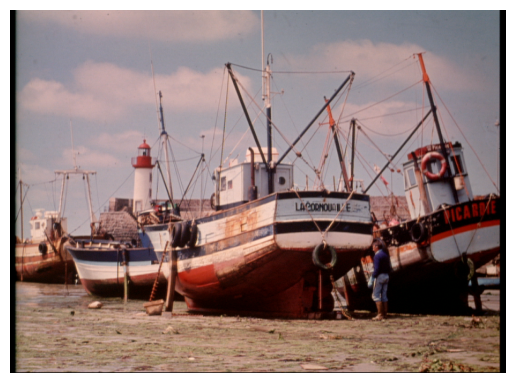

In [81]:
image = Image.open("datasets/images/boats.ppm")
print(image.size)
imshow(image)

# Simplifica a imagem

Para facilitar o exemplo vamos diminuir a resolução para 64x64 e pegar apenas o primeiro canal de cores

array([<Axes: >], dtype=object)

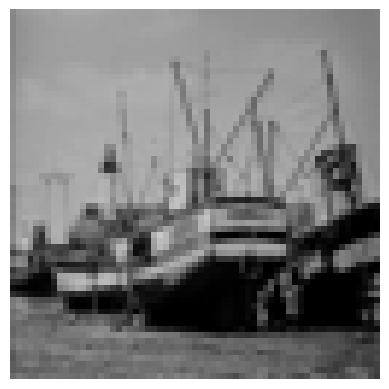

In [220]:
w, h = 64, 64
small_image = image.resize((w + 2, h + 2)).crop((1, 1, w, h)).getchannel(2)
imshow(small_image)

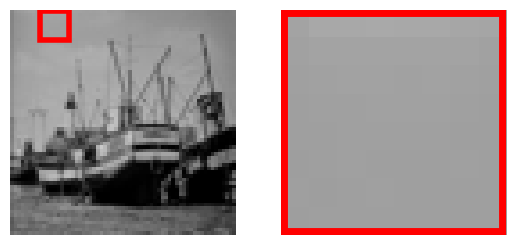

In [241]:
array = np.array(small_image)

size = 8
x, y = 8, 0
block = array[y:y+size, x:x+size]

axes = imshow(array, block)

rect = patches.Rectangle((x, y), size, size, fill=False, color="red", linewidth=4)
axes[0].add_patch(rect)

rect = patches.Rectangle((-0.5, -0.5), size, size, fill=False, color="red", linewidth=10)
axes[1].add_patch(rect)

min: -4
max: 1287


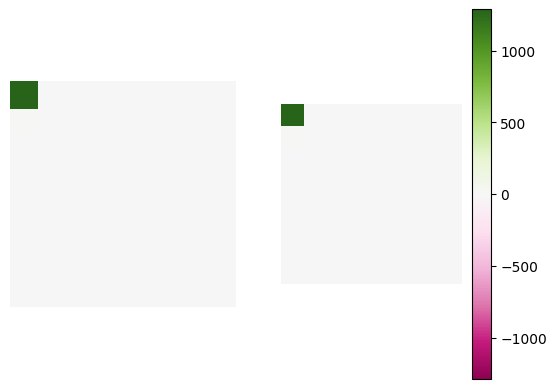

In [242]:
lower_bp = 3
mask = (1 << lower_bp) - 1

transformed = dctn(block, norm="ortho").astype(int)
quantized = transformed & ~mask

dctshow(transformed, quantized)

print("min:", transformed.min())
print("max:", transformed.max())

array([<Axes: >, <Axes: >], dtype=object)

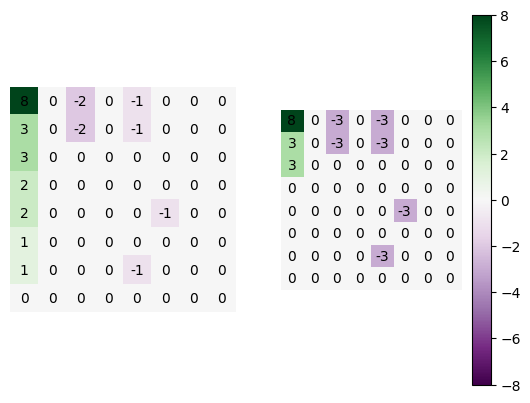

In [464]:
bp_show(transformed, quantized, show_texts=True)

In [498]:
def plot_mule(flags: Sequence[str], image: np.ndarray):
    flags = deque(flags)
    slices = bigger_possible_slice(image.shape)
    max_bitplane = int(image.size * 255).bit_length()

    bp_show(transformed, show_texts=True)
    axes = bp_show(transformed, show_texts=False)
    recursive_plot_mule(flags, slices, max_bitplane, image, ax=axes[0])
    plt.show()


def recursive_plot_mule(
    flags: deque[str],
    position: tuple[slice],
    bitplane: int,
    image: np.ndarray,
    ax: Optional[Axes] = None,
    transparency=0.3,
):
    start = tuple(s.start - 0.5 for s in reversed(position))
    lengths = tuple(s.stop - s.start for s in reversed(position))
    size = np.prod(lengths)

    if ax is None:
        ax = plt.gca()

    # Show how it was divided
    rec = patches.Rectangle(
        start,
        *lengths,
        linewidth=2,
        edgecolor="midnightblue",
        fill=False,
    )
    ax.add_patch(rec)

    if size == 0:
        return

    if size == 1:        
        ax.text(
            start[0] + lengths[0] / 2,
            start[1] + lengths[1] / 2,
            f"{bitplane}\nbits",
            ha="center",
            va="center",
            color="midnightblue"
        )
        return

    if not flags:
        rec = patches.Rectangle(
            start,
            *lengths,
            linewidth=2,
            edgecolor="red",
            facecolor=(1, 0, 0, 0.2),
        )
        ax.add_patch(rec)

        ax.text(
            start[0] + lengths[0] / 2,
            start[1] + lengths[1] / 2,
            f"{bitplane}\nbits",
            ha="center",
            va="center",
            color="red"
        )

        return

    flag = flags.popleft()

    if flag == "Z":
        rec = patches.Rectangle(
            start,
            *lengths,
            facecolor="midnightblue",
            alpha=0.8
        )
        ax.add_patch(rec)
        # ax.text(
        #     start[0] + lengths[0] / 2,
        #     start[1] + lengths[1] / 2,
        #     flag,
        #     ha="center",
        #     va="center",
        #     color=(1, 1, 1),
        # )

    elif flag == "L":
        # text = "L"
        # while (len(flags) >= 1) and (flags[0] == "L"):
        #     text += "L"
        #     flags.popleft()

        # rec = patches.Rectangle(
        #     start,
        #     *lengths,
        #     linewidth=1,
        #     edgecolor=(0, 1, 0),
        #     facecolor=(0, 1, 0, transparency),
        # )
        # ax.add_patch(rec)
        # ax.text(
        #     start[0] + lengths[0] / 2,
        #     start[1] + lengths[1] / 2,
        #     text,
        #     ha="center",
        #     va="center",
        #     color=(1, 1, 1),
        # )
        recursive_plot_mule(
            flags,
            position,
            bitplane - 1,
            image,
            ax=ax,
            transparency=transparency,
        )

    elif flag == "S":
        for sub_pos in split_shape_in_half(position):
            recursive_plot_mule(
                flags,
                sub_pos,
                bitplane,
                image,
                ax=ax,
                transparency=transparency,
            )

    else:
        raise ValueError("Invalid encoding")

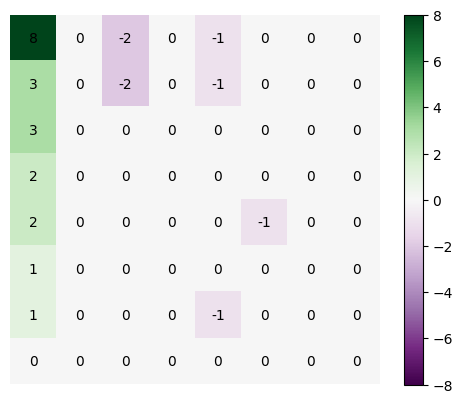

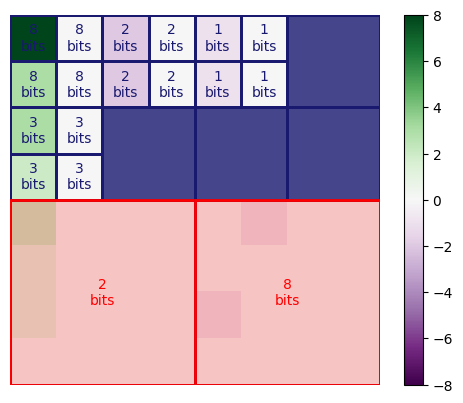

In [508]:
plot_mule("LLLLLLSSSLLLLLLSLLLLLSZLLLLLLLSSZZZLLLLLL", transformed)